In [1]:
import pandas as pd
from typing import List
import glob
import pathlib
import re
import matplotlib as mpl

import matplotlib.pyplot as plt

#matplotlib.use('TkAgg')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

ROW_TEMPLATE = {
    'dataset': None, 
    'overlap': None, 
    'algorithm': None, 
    'selection_metric': None, 
    'evaluation_metric': None,
    'selection_value': None,
    'evaluation_value': None,
    'selection_std': None,
    'evaluation_std': None,
    }
VIABLE_SELECTION_METRICS = ['acc', 'f1', 'oacc', 'nacc']
VIABLE_EVALUATION_METRICS = ['acc', 'f1', 'oacc', 'nacc']

In [2]:
# get latex files
latex_files = glob.glob('/Users/kimathikaai/scratch/saved/domainbed_results/**/*.tex', recursive=True)
assert not len(latex_files) % 16

### Playground for regex based string processing

In [3]:
# Playground for regex based string processing
txt = "\textbf{Algorithm}        & \textbf{VLCS}             & \textbf{OfficeHome}       & \textbf{Avg}              \\"
print(re.split("\s+", txt.replace("\textbf", ""
        ).replace("&", ""
        ).replace("{", ""
        ).replace("}", ""
        ).replace("\\", "").strip()))
print(re.split(
    "\s+", 
    re.sub(r"\textbf{(\w+)}", r"\1", 
           txt.replace("&", "").replace("\\", "")).strip()))

txt = "ERM                       & 75.6 $\pm$ 0.4            & 59.8 $\pm$ 0.7            & 67.7                      \\"
re.split(
    "\s+",
    txt.replace("$\pm$ ", "").replace("&", "").replace("\\", "").strip()
    )

['Algorithm', 'VLCS', 'OfficeHome', 'Avg']
['Algorithm', 'VLCS', 'OfficeHome', 'Avg']


['ERM', '75.6', '0.4', '59.8', '0.7', '67.7']

### Convert latex documents to a Pandas DataFrame

In [4]:
from IPython.core.debugger import set_trace
# file scraping function that returns a row
    # Inputs: file_path
    # Returns: row as defined by ROW_TEMPLATE (perform check in function)
def scrape_latex(latex_file_path) -> List[dict]:
    
    rows = []
        
    def get_header(line):
        header = re.split(
            "\s+", 
            re.sub(r"\\textbf{(\w+)}", r"\1", line.replace("&", "").replace(r"\\", "")).strip()
            )
        dataset_list = header[1: -1]
        return header, dataset_list

    # get selection and evaluation metric
    file_name = pathlib.Path(latex_file_path).stem
    selection_metric = file_name.split('_')[-2]
    evaluation_metric = file_name.split('_')[-1]
    overlap = file_name.split('_')[-3]
    
    #print(file_name, selection_metric, evaluation_metric, overlap)
    assert selection_metric in VIABLE_SELECTION_METRICS
    assert evaluation_metric in VIABLE_EVALUATION_METRICS
    
    # read file contents
    with open(latex_file_path, 'r') as f:
        found_section = False
        found_table = False
        found_header = False
        found_table_start = False
            
        lines = f.readlines()
        for row_n, line in enumerate(lines):
            
            # print(row_n,line)
            # get to training-domain model selection section
            if (re.search("subsection{Model.*training-domain", line) or found_section):
                #if not found_section: print("*"*10, line)
                found_section = True
                if (re.search("subsubsection{Averages}", line) or found_table):
                    #if not found_table: print("*"*10, line)
                    found_table = True
                    if (re.search("textbf{Algorithm}", line) or found_header):
                        if not found_header:
                            # therefore first time to find header
                            # get header items
                            header, dataset_list = get_header(line)
                            #print(header)
                            #print(dataset_list)
                            
                            found_header = True
                            
                        # look for table beginning
                        if ('midrule' in line or found_table_start):
                            if not found_table_start:
                                found_table_start = True
                                continue
                            
                            # don't process after /bottom/rule
                            if ('bottomrule' in line):
                                # finished reading table
                                break
                            
                            # strip the row for each algorithm for
                            # value and std per dataset
                            algo_row = re.split(
                                "\s+",
                                line.replace("$\\pm$ ", ""
                                    ).replace("&", ""
                                    ).replace(r"\\", ""
                                    ).strip()
                                )
                            algorithm = algo_row.pop(0)
                            average = algo_row.pop()
                            values = algo_row
                            #print("*"*10, algo_row)
                            
                            # Support 'X'
                            org_values = values[:]
                            values = []
                            for item in org_values:
                                if item == "X":
                                    values.extend(["X", "X"])
                                else:
                                    values.append(item)

                            for idx, dataset in enumerate(dataset_list):
                                if values[idx*2] == 'X': continue
                                if float(values[idx*2]) < 0: continue
                                    
                                try:
                                    row = {
                                        'dataset': dataset, 
                                        'overlap': overlap, 
                                        'algorithm': algorithm, 
                                        'selection_metric': selection_metric, 
                                        'evaluation_metric': evaluation_metric,
                                        'selection_value': None,
                                        'evaluation_value': float(values[idx*2]),
                                        'selection_std': None,
                                        'evaluation_std': float(values[idx*2 +1]),
                                    }
                                    rows.append(row)
                                except:
                                    set_trace()
                                    print(values)
    return rows
                        

data = []
# scrape each latex file
for file in latex_files:
    print('[info] processing: ', file)
    data.extend(scrape_latex(file))

# convert to pandas data frame
df = pd.DataFrame.from_dict(data)

[info] processing:  /Users/kimathikaai/scratch/saved/domainbed_results/66/domainbed_results_All_66_nacc_nacc.tex
[info] processing:  /Users/kimathikaai/scratch/saved/domainbed_results/66/domainbed_results_All_66_oacc_f1.tex
[info] processing:  /Users/kimathikaai/scratch/saved/domainbed_results/66/domainbed_results_All_66_oacc_oacc.tex
[info] processing:  /Users/kimathikaai/scratch/saved/domainbed_results/66/domainbed_results_All_66_acc_nacc.tex
[info] processing:  /Users/kimathikaai/scratch/saved/domainbed_results/66/domainbed_results_All_66_oacc_acc.tex
[info] processing:  /Users/kimathikaai/scratch/saved/domainbed_results/66/domainbed_results_All_66_nacc_f1.tex
[info] processing:  /Users/kimathikaai/scratch/saved/domainbed_results/66/domainbed_results_All_66_f1_f1.tex
[info] processing:  /Users/kimathikaai/scratch/saved/domainbed_results/66/domainbed_results_All_66_acc_f1.tex
[info] processing:  /Users/kimathikaai/scratch/saved/domainbed_results/66/domainbed_results_All_66_f1_oacc.te

### What is  the AVERAGE performance ACROSS DATASETS for each overlap and metric?

In [5]:
df.groupby(['overlap', 'selection_metric', 'evaluation_metric', 'algorithm']).mean()

/var/folders/kr/gtghwjcs55q1lrp82b0qv62h0000gn/T/ipykernel_24317/2889167385.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby(['overlap', 'selection_metric', 'evaluation_metric', 'algorithm']).mean()


evaluation_value  \
overlap selection_metric evaluation_metric algorithm                      
0       acc              acc               ARM                41.166667   
                                           CAD                39.266667   
                                           CORAL              42.666667   
                                           ERM                41.533333   
                                           MLDG               40.433333   
                                           SelfReg            40.966667   
                                           Transfer           41.566667   
                         f1                ARM                35.733333   
                                           CAD                32.933333   
                                           CORAL              36.400000   
                                           ERM                36.600000   
                                           MLDG               34.566667   
                                           SelfReg            34.866667   
                                           Transfer           36.133333   
                         nacc              ARM                41.300000   
                                           CAD                38.300000   
                                           CORAL              42.033333   
                                           ERM                41.833333   
                                           MLDG               40.366667   
                                           SelfReg            40.500000   
                                           Transfer           41.800000   
        f1               acc               ARM                40.733333   
                                           CAD                39.233333   
                                           CORAL              42.200000   
                                           ERM                40.966667   
                                           MLDG               41.300000   
                                           SelfReg            40.900000   
                                           Transfer           41.600000   
                         f1                ARM                35.500000   
                                           CAD                33.066667   
                                           CORAL              36.233333   
                                           ERM                35.566667   
                                           MLDG               35.666667   
                                           SelfReg            34.833333   
                                           Transfer           36.066667   
                         nacc              ARM                40.766667   
                                           CAD                38.566667   
                                           CORAL              41.833333   
                                           ERM                41.500000   
                                           MLDG               41.133333   
                                           SelfReg            40.533333   
                                           Transfer           42.033333   
        nacc             acc               ARM                41.466667   
                                           CAD                39.366667   
                                           CORAL              43.000000   
                                           ERM                40.833333   
                                           MLDG               40.800000   
                                           SelfReg            40.866667   
                                           Transfer           41.433333   
                         f1                ARM                36.100000   
                                           CAD                33.333333   
                                           CORAL              36.566667   
     

### On average what is the best selection metric for an evaluation metric?

In [6]:
df.loc[
    #(df['dataset'] == 'PACS')
#     (df['overlap'] == '33') &
     #((df['evaluation_metric'] == 'nacc') | (df['evaluation_metric'] == 'acc')) &
    (df['evaluation_metric'] == 'nacc') &
    ((df['selection_metric'] == 'nacc') | (df['selection_metric'] == 'f1'))
].groupby(['dataset','overlap', 'selection_metric', 'evaluation_metric']).mean()

/var/folders/kr/gtghwjcs55q1lrp82b0qv62h0000gn/T/ipykernel_24317/2167025168.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.loc[


evaluation_value  \
dataset    overlap selection_metric evaluation_metric                     
OfficeHome 0       f1               nacc                      40.600000   
                   nacc             nacc                      40.757143   
           33      f1               nacc                      39.381818   
                   nacc             nacc                      39.490909   
           66      f1               nacc                      38.270000   
                   nacc             nacc                      38.780000   
PACS       0       f1               nacc                      40.285714   
                   nacc             nacc                      40.100000   
           33      f1               nacc                      34.238462   
                   nacc             nacc                      35.630769   
           66      f1               nacc                      13.115385   
                   nacc             nacc                      15.615385   
           high    f1               nacc                      56.950000   
                   nacc             nacc                      57.800000   
           low     f1               nacc                      43.500000   
                   nacc             nacc                      45.650000   
           mid     f1               nacc                      39.262500   
                   nacc             nacc                      41.487500   
VLCS       0       f1               nacc                      41.842857   
                   nacc             nacc                      42.585714   
           33      f1               nacc                      46.322222   
                   nacc             nacc                      47.800000   
           66      f1               nacc                      36.910000   
                   nacc             nacc                      49.640000   

                                                       evaluation_std  
dataset    overlap selection_metric evaluation_metric                  
OfficeHome 0       f1               nacc                     0.514286  
                   nacc             nacc                     0.485714  
           33      f1               nacc                     0.472727  
                   nacc             nacc                     0.381818  
           66      f1               nacc                     0.510000  
                   nacc             nacc                     0.550000  
PACS       0       f1               nacc                     0.785714  
                   nacc             nacc                     0.800000  
           33      f1               nacc                     0.830769  
                   nacc             nacc                     0.953846  
           66      f1               nacc                     0.969231  
                   nacc             nacc                     1.400000  
           high    f1               nacc                     0.500000  
                   nacc             nacc                     0.950000  
           low     f1               nacc                     1.100000  
                   nacc             nacc                     0.600000  
           mid     f1               nacc                     0.825000  
                   nacc             nacc                     0.900000  
VLCS       0       f1               nacc                     1.100000  
                   nacc             nacc                     1.071429  
           33      f1               nacc                     0.733333  
                   nacc             nacc                     1.088889  
           66      f1               nacc                     1.990000  
                   nacc             nacc                     2.850000

### What is the performance across dataset, overlap and metric?

In [7]:
df.loc[
    (df['dataset'] == 'PACS') &
    (df['overlap'] == '66') &
    (df['evaluation_metric'] == 'nacc')
].groupby(['dataset','overlap', 'selection_metric', 'evaluation_metric', 'algorithm']).mean()

/var/folders/kr/gtghwjcs55q1lrp82b0qv62h0000gn/T/ipykernel_24317/2849385148.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.loc[


evaluation_value  \
dataset overlap selection_metric evaluation_metric algorithm                      
PACS    66      acc              nacc              ARM                     12.5   
                                                   CAD                     11.8   
                                                   CORAL                   13.0   
                                                   ERM                     11.6   
                                                   Intra                   12.1   
                                                   Intra_XDom              12.6   
                                                   MLDG                    14.0   
                                                   SelfReg                 12.9   
                                                   SupCon                  12.8   
                                                   Transfer                15.4   
                                                   XDom                    14.5   
                                                   XDomBatch               14.2   
                                                   XDomError               15.2   
                f1               nacc              ARM                     10.7   
                                                   CAD                     11.2   
                                                   CORAL                   12.2   
                                                   ERM                     10.9   
                                                   Intra                   13.9   
                                                   Intra_XDom              14.3   
                                                   MLDG                    14.0   
                                                   SelfReg                 12.0   
                                                   SupCon                  13.2   
                                                   Transfer                15.8   
                                                   XDom                    14.4   
                                                   XDomBatch               13.0   
                                                   XDomError               14.9   
                nacc             nacc              ARM                     16.2   
                                                   CAD                     13.1   
                                                   CORAL                   13.7   
                                                   ERM                     13.7   
                                                   Intra                   17.6   
                                                   Intra_XDom              15.6   
                                                   MLDG                    13.8   
                                                   SelfReg                 13.4   
                                                   SupCon                  17.3   
                                                   Transfer                16.0   
                                                   XDom                    18.0   
                                                   XDomBatch               14.9   
                                                   XDomError               19.7   
                oacc             nacc              ARM                      9.2   
                                                   CAD                      9.0   
                                                   CORAL                   11.6   
                                                   ERM                     12.1   
                                                   Intra                   11.8   
                                                   Intra_XDom              11.3   
                                                   MLDG                    13.3   
                                                   SelfReg                 11.5

### What is the difference between "oacc" and "noacc"?

In [8]:
cols = ['dataset', 'overlap', 'selection_metric', 'evaluation_metric', 'algorithm']

# nacc DNE in full overlap and oacc DNE in none overlap
data = df.loc[(
    (df['overlap'] == '33') | (df['overlap'] == '66') | 
    (df['overlap'] == 'mid') | (df['overlap'] == 'low')
)]

cols_a = ['dataset', 'algorithm', 'overlap', 'selection_metric', 'evaluation_value']
df_oacc = data[data['evaluation_metric'] == 'oacc'][cols_a].sort_values(
    by=cols_a, ascending=True).reset_index(drop=True)
df_nacc = data[data['evaluation_metric'] == 'nacc'][cols_a].sort_values(
    by=cols_a, ascending=True).reset_index(drop=True)

assert len(df_nacc) == len(df_oacc)
df_oacc['oacc-nacc'] = df_oacc['evaluation_value'] - df_nacc['evaluation_value']
data = df_oacc[['dataset', 'algorithm', 'overlap', 'selection_metric', 'oacc-nacc']]
a = data.groupby(['dataset', 'overlap', 'selection_metric','algorithm', 'oacc-nacc']).mean()

### What is the top performing algorithm for each dataset, overlap, and metric?
- For OfficeHome (33&66) the non-overlapping accuracy is highest for (XDom, Intra and SupCon approaches) consistently
- In general XDom shines the most with the availability of overlapping classes to benefit the non-overlapping classes (having a memory queue for under represented samples would help)
    - However we can also reduce the scope of the problem by focusing on 50%-75% overlap cases and/or performing random class selection
- (PACS 66) (selec, eval)
    - (acc,acc) XDom, XDomBatch, XDomError
    - (acc,f1) XDom, XDomError, XDomBatch
    - (acc,nacc) Transfer with 0.2% difference from XDomError with 0.7% difference from XDom

In [9]:
cols = ['dataset', 'overlap', 'selection_metric', 'evaluation_metric', 'algorithm']
base_group = df.loc[
#         (df['algorithm'] != 'XDom') &
#         (df['algorithm'] != 'Intra') &
#         (df['algorithm'] != 'SupCon') &
#         (df['algorithm'] != 'Intra_XDom') &
#         ((df['dataset'] == 'PACS') | (df['dataset'] == 'OfficeHome'))  &
#         (df['overlap'] == 66) &
        (df['algorithm'] != 'XDomBatch')
    ].groupby(cols)
base_group.mean().loc[
    base_group.mean().groupby(cols[:-1])['evaluation_value'].idxmax()
]

/var/folders/kr/gtghwjcs55q1lrp82b0qv62h0000gn/T/ipykernel_24317/3777563572.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  base_group.mean().loc[
/var/folders/kr/gtghwjcs55q1lrp82b0qv62h0000gn/T/ipykernel_24317/3777563572.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  base_group.mean().groupby(cols[:-1])['evaluation_value'].idxmax()


evaluation_value  \
dataset    overlap selection_metric evaluation_metric algorithm                      
OfficeHome 0       acc              acc               CORAL                   46.5   
                                    f1                CORAL                   42.8   
                                    nacc              CORAL                   45.0   
                   f1               acc               CORAL                   46.2   
                                    f1                CORAL                   42.4   
                                    nacc              CORAL                   44.7   
                   nacc             acc               CORAL                   46.3   
                                    f1                CORAL                   42.6   
                                    nacc              CORAL                   44.8   
                   oacc             acc               CAD                      2.2   
                                    f1                CAD                      0.9   
                                    nacc              CAD                      2.0   
           100     acc              acc               CORAL                   62.6   
                                    f1                CORAL                   60.6   
                                    oacc              CORAL                   61.4   
                   f1               acc               CORAL                   62.7   
                                    f1                CORAL                   60.6   
                                    oacc              CORAL                   61.5   
                   nacc             acc               ARM                      2.1   
                                    f1                ARM                      0.9   
                                    oacc              CAD                      2.1   
                   oacc             acc               CORAL                   62.7   
                                    f1                CORAL                   60.7   
                                    oacc              CORAL                   61.4   
           33      acc              acc               CORAL                   50.1   
                                    f1                CORAL                   46.7   
                                    nacc              SupCon                  41.7   
                                    oacc              CORAL                   61.7   
                   f1               acc               CORAL                   50.3   
                                    f1                CORAL                   46.6   
                                    nacc              Intra                   41.2   
                                    oacc              CORAL                   62.0   
                   nacc             acc               CORAL                   49.9   
                                    f1                CORAL                   46.2   
                                    nacc              SupCon                  41.0   
                                    oacc              CORAL                   61.5   
                   oacc             acc               CORAL                   50.1   
                                    f1                CORAL                   46.4   
                                    nacc              Intra                   40.7   
                                    oacc              CORAL                   61.8   
           66      acc              acc               XDom                    53.7   
                                    f1                XDom                    49.9   
                                    nacc              XDom                    40.8   
                                    oacc              CORAL                   60.7   
                   f1               acc               XDom                    54.0   
                        

## Plot Results Across "Datasets" and "Overlaps"
- XDomError performance drop for lower overlaps is worse than XDom
- For selec_methods = 'acc' and 'f1', XDomError 'nacc' is not strongest 

/var/folders/kr/gtghwjcs55q1lrp82b0qv62h0000gn/T/ipykernel_24317/582013246.py:63: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_results(df=df, selec_metric=s, eval_metric=e).show()
/var/folders/kr/gtghwjcs55q1lrp82b0qv62h0000gn/T/ipykernel_24317/582013246.py:63: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_results(df=df, selec_metric=s, eval_metric=e).show()
/var/folders/kr/gtghwjcs55q1lrp82b0qv62h0000gn/T/ipykernel_24317/582013246.py:63: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_results(df=df, selec_metric=s, eval_metric=e).show()
/var/folders/kr/gtghwjcs55q1lrp82b0qv62h0000gn/T/ipykernel_24317/582013246.py:63: UserWarning: Matplotlib is currently using module://matplotlib_inline

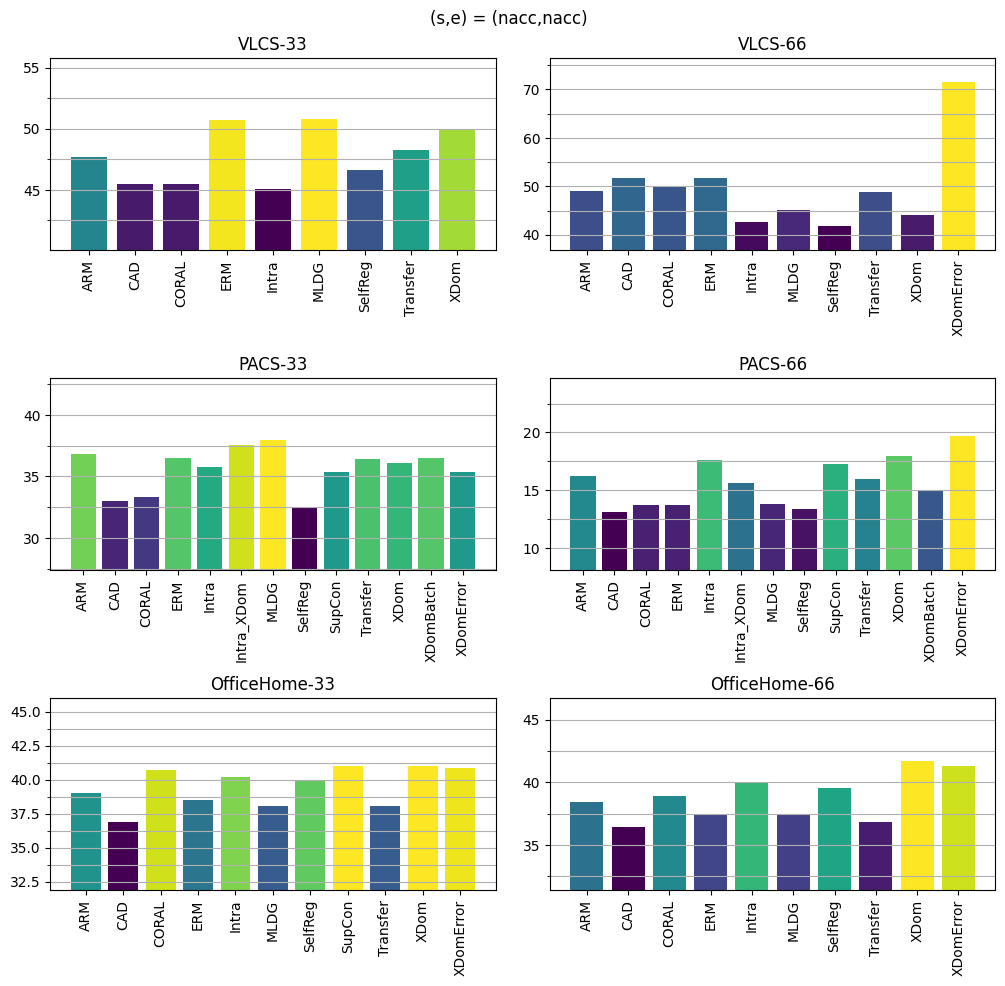

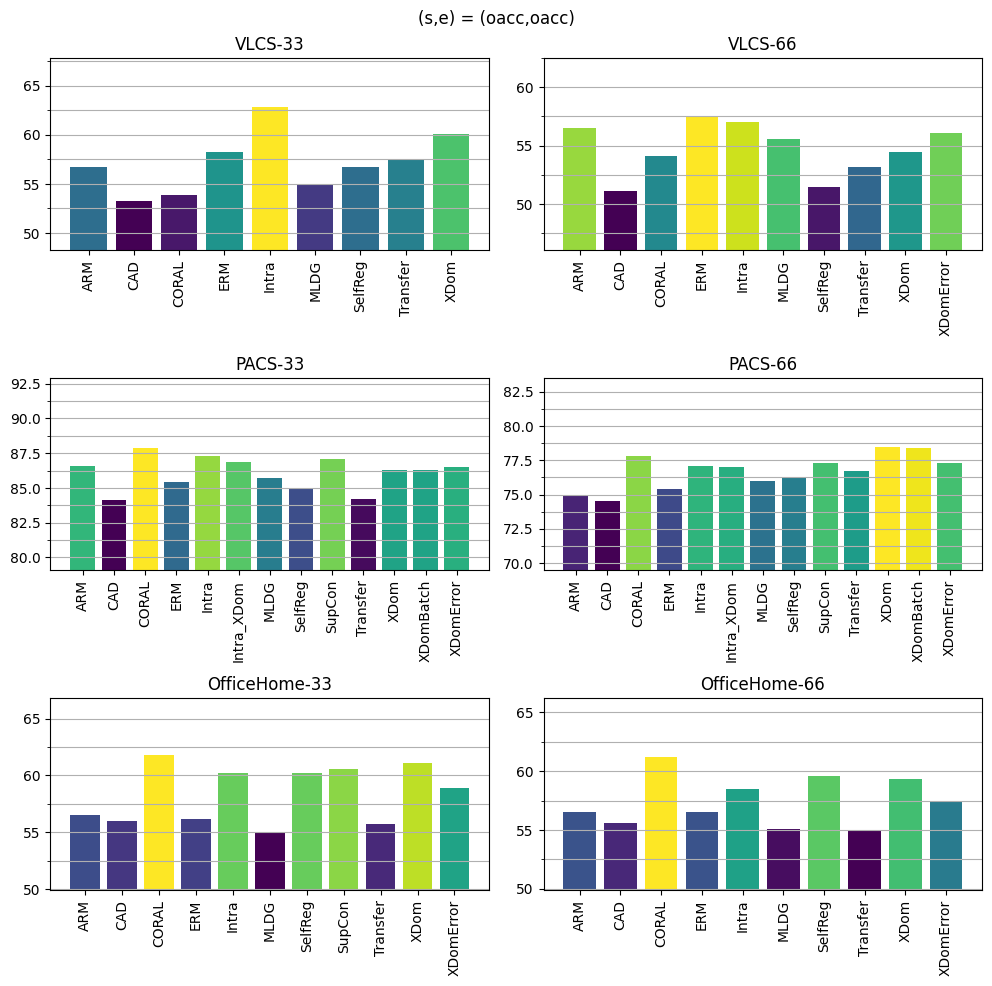

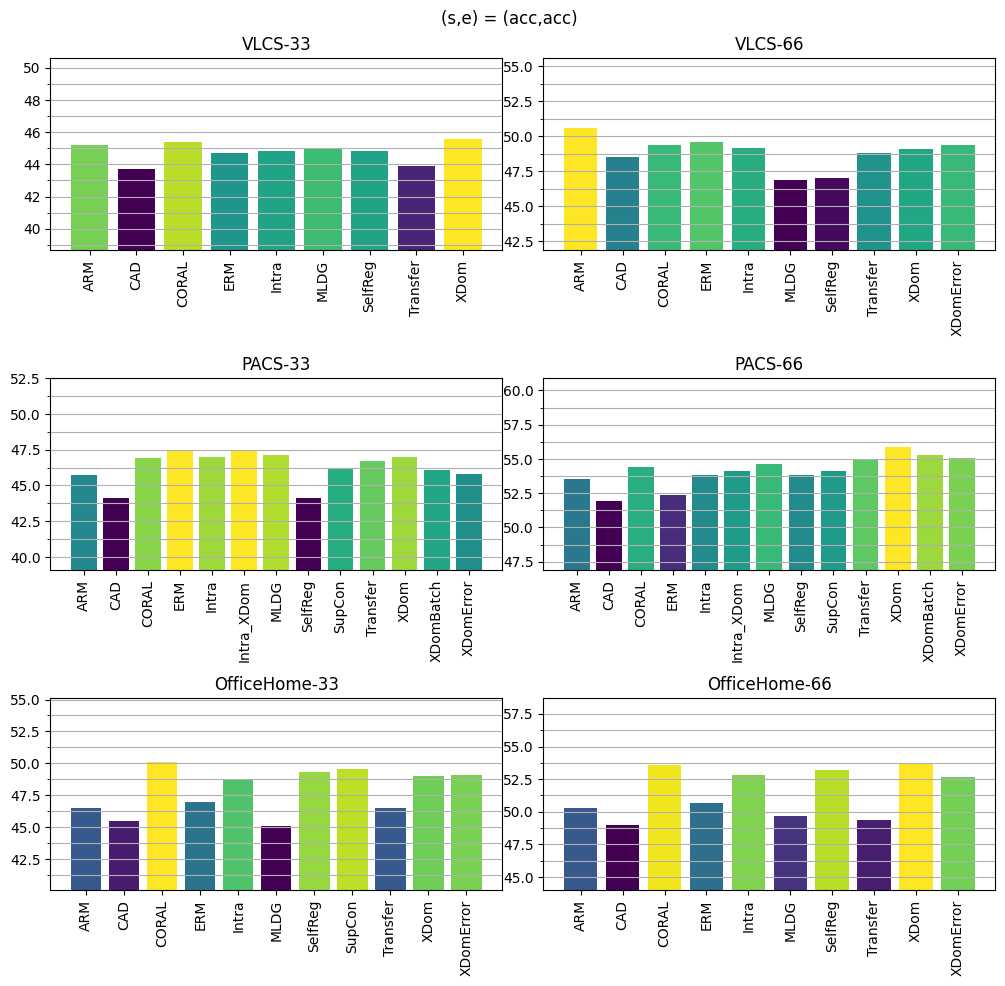

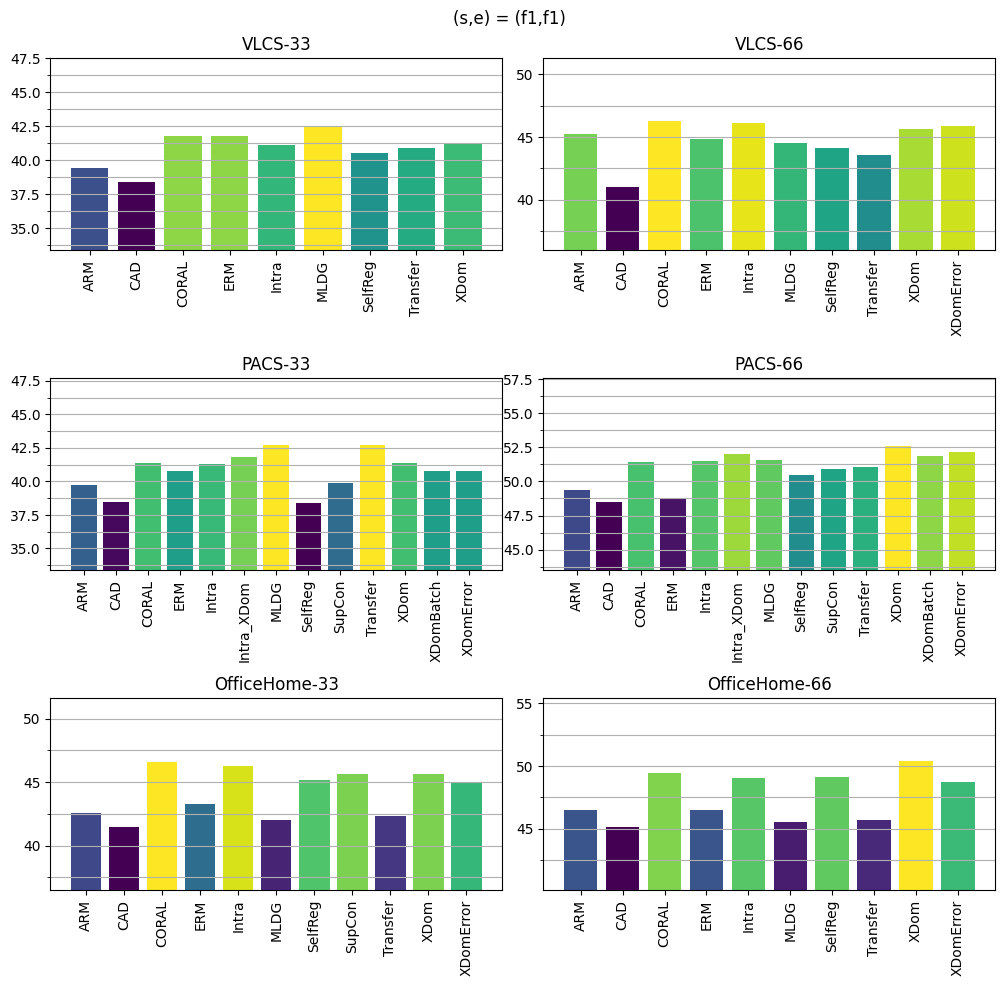

In [14]:
import numpy as np
from matplotlib.ticker import AutoMinorLocator
import itertools

def plot_results(df, selec_metric, eval_metric):
    dataset_list = list(df["dataset"].unique())
    #dataset_list = ["PACS"]
    overlap_list = ['33', '66']
    #overlap_list = ['low','33', 'mid', '66', 'high']

    my_cmap = plt.get_cmap("viridis")
    rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

    fig, ax = plt.subplots(
        nrows = len(dataset_list),
        ncols = len(overlap_list),
        figsize=(10,10),
        #figsize=(10,5),
        sharey=False)
    
    #ax = [ax]

    for i, dataset in enumerate(dataset_list):
        for j, overlap in enumerate(overlap_list):
            data = df.loc[
                (df['dataset'] == dataset) &
                (df['selection_metric'] == selec_metric) &
                (df['evaluation_metric'] == eval_metric) &
                (df['overlap'] == overlap)
            ].sort_values(by=['algorithm'], ascending=True)
            
            ax[i][j].bar(
                data.algorithm, 
                data.evaluation_value, 
                color=my_cmap(rescale(data.evaluation_value)))

            #plot_data = df_group.mean()['evaluation_value']
            #max_algo = plot_data.idxmax()
            #print(plot_data)

            #plot_data.plot(ax=ax[i][j], kind="bar")
            ax[i][j].set_title(f"{dataset}-{overlap}")
            #ax[i][j].set_yticks(np.arange(20,60,5))
            ax[i][j].yaxis.set_minor_locator(AutoMinorLocator(2))
            ax[i][j].set_ylim(
                min(data.evaluation_value) - 5,
                max(data.evaluation_value) + 5)
            #ax[i][j].set_ylim(40, 60)
            ax[i][j].grid(axis="y", which="both")
            ax[i][j].tick_params(axis='x', labelrotation=90)
            # ax[i][j].legend()
    
    fig.suptitle(f"(s,e) = ({selec_metric},{eval_metric})")
    fig.tight_layout(pad=1.0, h_pad=1.0)
    return fig

sl = list(df["selection_metric"].unique())
el = list(df["evaluation_metric"].unique())
sl_el = itertools.product(sl, el)
for s, e in sl_el:
    if e != s: continue
    # if e != 'f1' or s != 'f1': continue
    plot_results(df=df, selec_metric=s, eval_metric=e).show()
# plot_results(df=df, selec_metric='acc', eval_metric='f1').show()
# plot_results(df=df, selec_metric='acc', eval_metric='nacc').show()

## Plot the stacked relationship between datasets and all overlaps
- The purpose is to provide a visualization of the the non-overlapping performance across data sets averaged over the different overlap cases

/var/folders/kr/gtghwjcs55q1lrp82b0qv62h0000gn/T/ipykernel_24317/355427692.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array(values)


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (10,) and arg 3 with shape (9,).

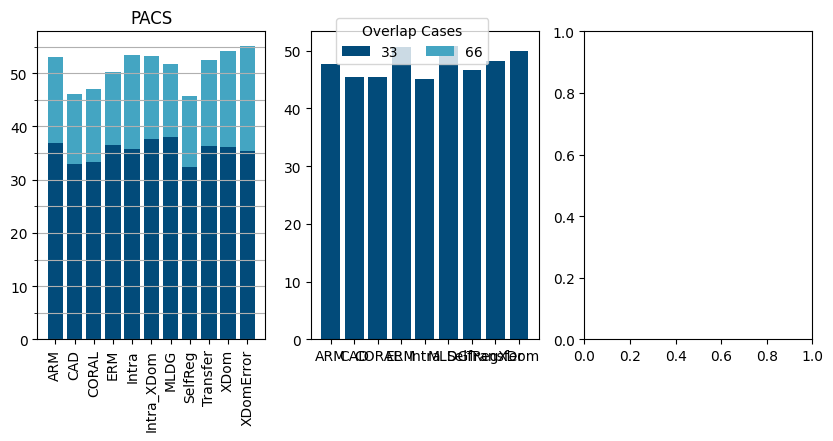

In [11]:
from matplotlib.ticker import AutoMinorLocator
def stack_plot_results(df, selec_metric, eval_metric):
    dataset_list = ['PACS','VLCS','OfficeHome']
    overlap_list = ['33', '66']
    color = ['#024b7a', '#44a5c2']
    
    fig, ax = plt.subplots(
        nrows = 1,
        ncols = len(dataset_list),
        #figsize=(10,10),
        figsize=(10,4),
        sharey=False)
    
    for i, dataset in enumerate(dataset_list):
        data = df.loc[
            (df['dataset'] == dataset) &
            (df['selection_metric'] == selec_metric) &
            (df['evaluation_metric'] == eval_metric) &
            (df['algorithm'] != 'SupCon') &
            #(df['algorithm'] != 'Intra') &
            #(df['algorithm'] != 'Intra_XDom') &
            (df['algorithm'] != 'XDomBatch')
        ].sort_values(by=['algorithm'], ascending=True)
        
        values = []
        for overlap in overlap_list:
            values.append(
                list(data.loc[(df['overlap'] == overlap)]['evaluation_value'])
            )
        values = np.array(values)
        
        # set_trace()
        # stack bar charts
        for j in range(values.shape[0]):
            ax[i].bar(
                x = list(data[data['overlap'] == overlap_list[j]]['algorithm'].unique()),
                height = values[j],
                bottom = np.sum(values[:j], axis=0),
                color=color[j],
                label=overlap_list[j]
            ) 
        ax[i].set_title(dataset)
        ax[i].set_ylabel = selec_metric
        ax[i].tick_params(axis='x', labelrotation=90)
        ax[i].grid(axis="y", which="both")
        ax[i].yaxis.set_minor_locator(AutoMinorLocator(2))
        
        if i == 0:
            handles, labels = ax[i].get_legend_handles_labels()
            fig.legend(
                handles,
                labels, 
                loc="upper center",
                title="Overlap Cases",
                ncols=len(overlap_list),
                bbox_to_anchor=(0.5, .93)
            )
    
    fig.suptitle(f"(s,e) = ({selec_metric},{eval_metric})")
    #fig.legend(loc="upper center", title="Overlap Case", ncols=2)
    fig.tight_layout(pad=3.0, w_pad=1.0)
    return fig

sl = list(df["selection_metric"].unique())
el = list(df["evaluation_metric"].unique())
sl_el = itertools.product(sl, el)
for s, e in sl_el:
    if e != 'nacc' or s != 'nacc': continue
    stack_plot_results(df=df, selec_metric=s, eval_metric=e).show()

## Plot the relationship between "nacc" and "oacc"
- Could average across: datasets, overlaps, selection_metrics
    - Across datasets would be the most beneficial and easiest to justify
- Purpose of this plot is display the relationship between non-overlapping and overlapping class accuracies for different methods

In [ ]:
color_metric = "acc"

def get_metric(data, eval_metric, selec_metric='acc'):
    """Averaging across overlaps and datasets"""
    print(f"({selec_metric}, {eval_metric})")
    data = df.loc[
        (df['dataset'] != 'VLCS') &
        (df['selection_metric'] == selec_metric) &  
        (df['evaluation_metric'] == eval_metric) &
        ((df['overlap'] == '33') | (df['overlap'] == '66')) &
        (df['algorithm'] != 'XDomBatch') &
        (df['algorithm'] != 'SupCon') &
        (df['algorithm'] != 'Intra') &
        (df['algorithm'] != 'Intra_XDom')
    ].sort_values(by='algorithm', ascending=True).reset_index(drop=True)
    
    cols = ['algorithm', 'overlap', 'dataset', 'evaluation_value']
    # print(data.groupby(cols).mean())
    metric_data = data.groupby('algorithm').mean().reset_index(names="algorithm")
    print(metric_data)
    return metric_data


df_oacc = get_metric(data, 'oacc')
df_nacc = get_metric(data, 'nacc')
df_acc = get_metric(data, 'acc')
assert len(df_oacc) == len(df_nacc) == len(df_acc)

# dataframe 
data = pd.DataFrame(data={
    'algorithm': df_oacc['algorithm'],
    'nacc': df_nacc['evaluation_value'],
    'oacc': df_oacc['evaluation_value'],
    'acc': df_acc['evaluation_value'],
    'diff': df_oacc['evaluation_value'] - df_nacc['evaluation_value'],
})
data = data.sort_values(by=color_metric, ascending=False).reset_index(drop=True)
print(data)
# TODO: scale  nacc and oacc for error line to be drawn

# colour map
my_cmap = plt.get_cmap("viridis")
def rescale(row, rows):
    return (row - np.min(rows)) / (np.max(rows) - np.min(rows))

# scatter plot
fig, ax = plt.subplots(figsize=(4,4))
markers = ['v','X','.', 'o', '1','s','p', 'P', '*', 'D', 'd', '>']
assert len(markers) >= len(data)
for index, row in data.iterrows():
    ax.scatter(
#         x=rescale(row['nacc'], data['nacc']),
#         y=rescale(row['oacc'], data['oacc']),
        x=row['nacc'],
        y=row['oacc'],
        color=my_cmap(rescale(row[color_metric], data[color_metric])),
        label=row['algorithm'],
        marker=markers[index],
        s=mpl.rcParams['lines.markersize'] ** 2.3
    )
# ax.plot([0,1], [0,1], 'k--')
ax.set_xlabel("Non-overlapping Accuracy")
ax.set_ylabel("Overlapping Accuracy")
ax.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
# ax.legend(loc='lower right', ncols=2, fontsize="9")
plt.show()